# Setup

In [37]:
import os
import random
from copy import deepcopy
from dataclasses import dataclass
from tqdm import tqdm

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import numpy as np
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )    
import wandb
import matplotlib.pyplot as plt

from data.datasets.web_dataset import get_dataset
from instructflow.utils import show_images, seed_everything   
from instructflow.generation import generate_euler, generate_euler_cfg, generate_midpoint, generate_midpoint_cfg

In [2]:
import yaml
from omegaconf import OmegaConf
import tempfile


with open("configs/sd2_baseline.yaml", "r") as fp:
    config = OmegaConf.load(fp.name)

In [3]:
DEVICE = "cuda:1"

In [4]:
seed_everything(config.system.random_state)
torch.set_float32_matmul_precision(config.system.pf32_precision)

In [5]:
scale = T.Lambda(
    lambda x: x * 2 - 1
)

inverse_scale = T.Lambda(
    lambda x: (x + 1) / 2
)


transform = T.Compose([
    T.ToTensor(),
    scale
])

inverse_transform = T.Compose([
    inverse_scale,
    T.Lambda(lambda x: x.permute(1, 2, 0))
])

# Generating Images from Text

In [6]:
# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(config.model.model_id).to(DEVICE)

/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

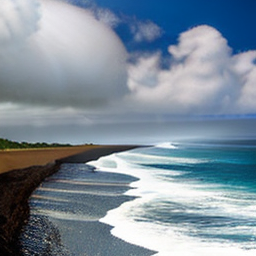

In [7]:
# Set up a generator for reproducibility
generator = torch.Generator(DEVICE).manual_seed(config.system.random_state)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Surfer on maui", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=256, 
    width=256,     # Specify the image size
    guidance_scale=4,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

In [8]:
import math

approx_num_samples, dataset = get_dataset(config.data)
approx_num_batches = math.ceil(approx_num_samples / config.data.dataloader.batch_size)

dataloader = DataLoader(
        dataset,
        batch_size=config.data.dataloader.batch_size,
        num_workers=config.data.dataloader.num_workers,
        pin_memory=True,
    )

!!! DATASET SIZE !!! 278964


# Model

In [9]:
last_base_checkpoint = os.listdir("/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_fm_generation_v1/")[-1]
last_base_checkpoint

'595000.pt'

In [10]:
base_unet = deepcopy(pipe.unet)
base_unet.load_state_dict(torch.load(f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_fm_generation_v1/{last_base_checkpoint}"))

<All keys matched successfully>

In [11]:
last_rf_2_checkpoint = os.listdir("/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_rf_2_generation_v1/")[-1]
last_rf_2_checkpoint

'29000.pt'

In [12]:
rf_unet = deepcopy(pipe.unet)
rf_unet.load_state_dict(torch.load(f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_rf_2_generation_v1/{last_rf_2_checkpoint}"))

<All keys matched successfully>

In [13]:
last_rf_distil_checkpoint = os.listdir("/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_rf_distill_generation_v1/")[-1]
last_rf_distil_checkpoint

'17000.pt'

In [14]:
rf_distil_unet = deepcopy(pipe.unet)
rf_distil_unet.load_state_dict(torch.load(f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_rf_distill_generation_v1/{last_rf_distil_checkpoint}"))

<All keys matched successfully>

In [20]:
vae = pipe.vae
tokenizer = pipe.tokenizer 
text_encoder = pipe.text_encoder

In [16]:
batch = next(iter(dataloader))
batch

/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (167076000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (104040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 

# Generation

In [17]:
device = DEVICE
device

'cuda:1'

In [18]:
x_1, input_ids, attention_mask = batch
x_1, input_ids, attention_mask = x_1[:16].to(device), input_ids[:16].to(device), attention_mask[:16].to(device)

with torch.no_grad():
    x_1_latents = 0.18215 * vae.encode(x_1).latent_dist.mean

x_0_latent = torch.randn_like(x_1_latents, device=device)
x_0_latent.shape

torch.Size([16, 4, 32, 32])

In [21]:
null_prompts = [''] * 16
null_encoder_out = pipe.tokenizer(null_prompts, padding="max_length", max_length=32, return_tensors="pt")

with torch.no_grad():
    null_encoder_hidden_states = text_encoder(null_encoder_out["input_ids"].to(device), null_encoder_out["attention_mask"].to(device))['last_hidden_state']

null_encoder_hidden_states.shape

torch.Size([16, 32, 1024])

In [22]:
prompts = [
    "Yellow elephant, high resolution 4k",
    "Red jetski in the center of field with green graaa, 4k high resolution",
    "DJ in Sunglasses, hight resolution",
    "Rainbow Crystall, bright, 4k",
    "Hot dog and a dog in front of an Eifel Tower",
    "Pink Razer Kitty Earphones",
    "Pillow and blanket sleeping on the bed in a form of a human",
    "Neuralk Network",
    "Heisenberg synthesyzed crystal sugar",
    "Window with a Mars platen in it",
    "Beautil blue Sea",
    "Surfer on Maui, hight resolution, 4k",
    "Russian Person, hight resolution",
    "Russian Flag",
    "3 Kids playing baseball, cartoon style",
    "Researchers in the laboratory"    
]

encoder_out = pipe.tokenizer(prompts, padding="max_length", max_length=32, return_tensors="pt")

with torch.no_grad():
    encoder_hidden_states = text_encoder(encoder_out["input_ids"].to(device), encoder_out["attention_mask"].to(device))['last_hidden_state']

encoder_hidden_states.shape

torch.Size([16, 32, 1024])

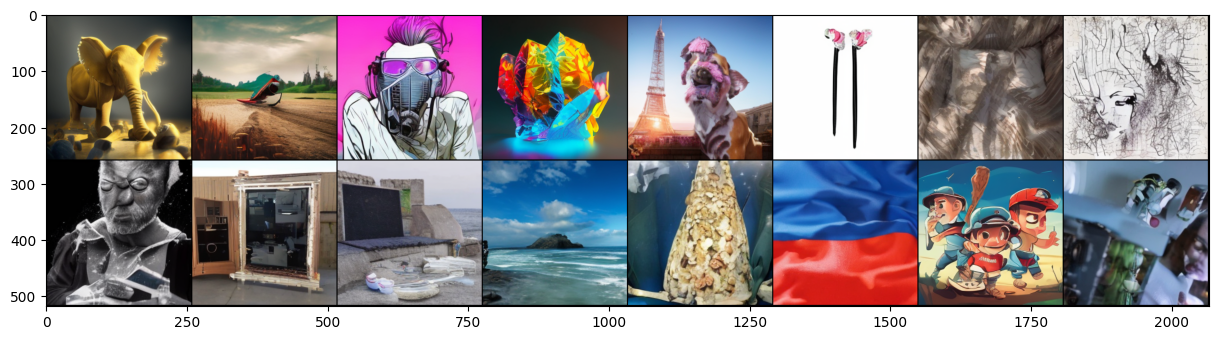

In [24]:
x_gen = generate_euler(unet=base_unet, vae=vae, x_0=x_0_latent[:16], encoder_hidden_states=encoder_hidden_states[:16], device=device)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen))

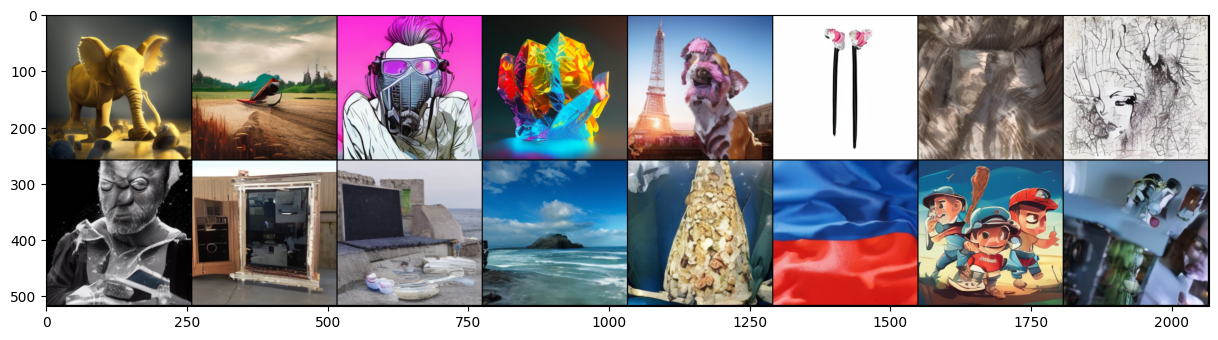

In [25]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=1,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

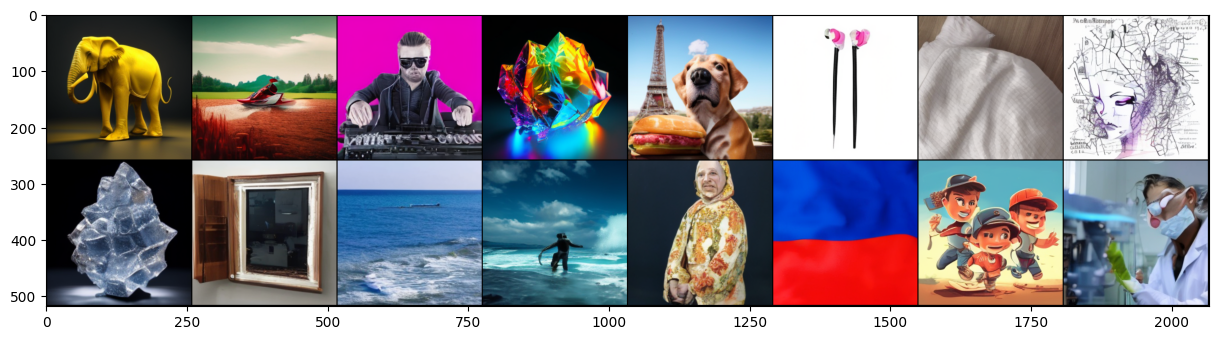

In [26]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=2,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

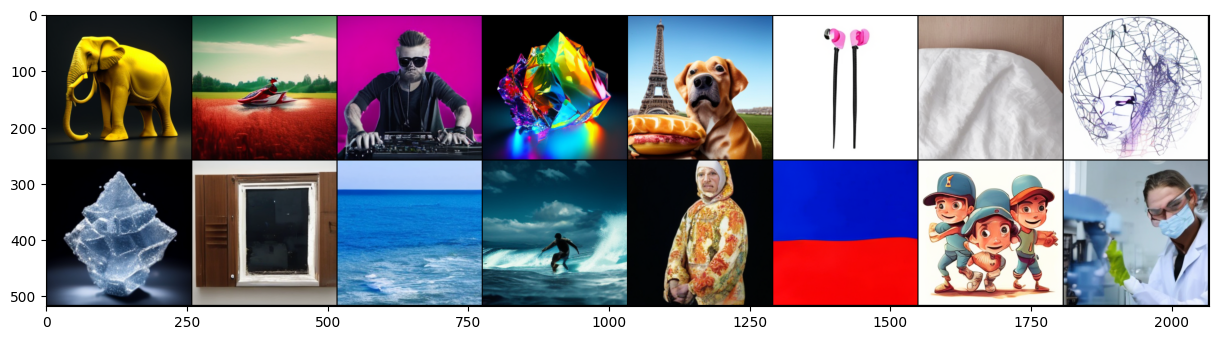

In [27]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=3,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

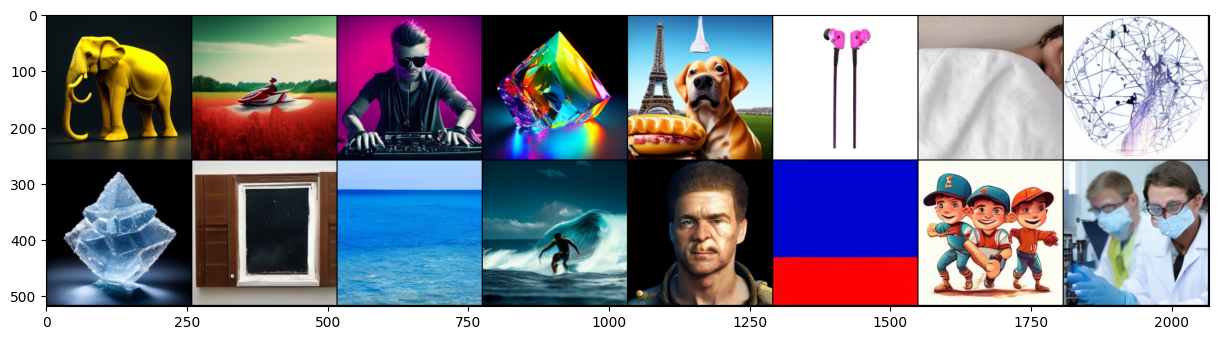

In [28]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=4,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

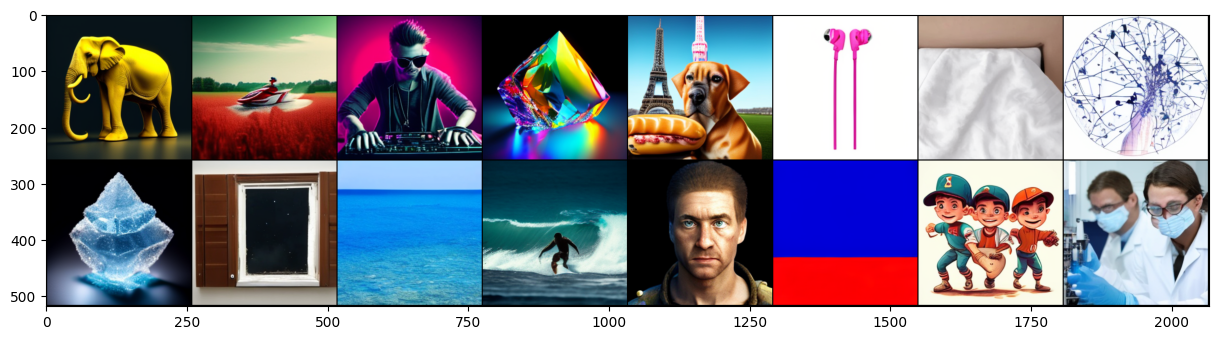

In [29]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=5,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

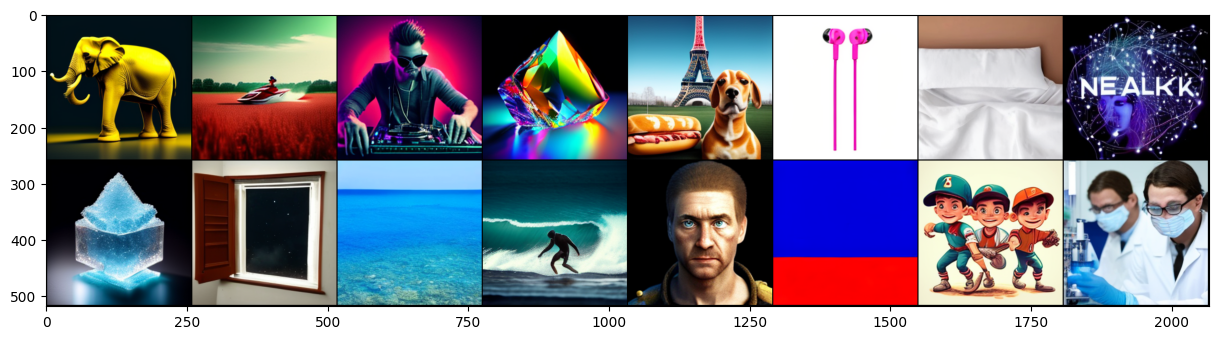

In [30]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=7,
    device=device
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

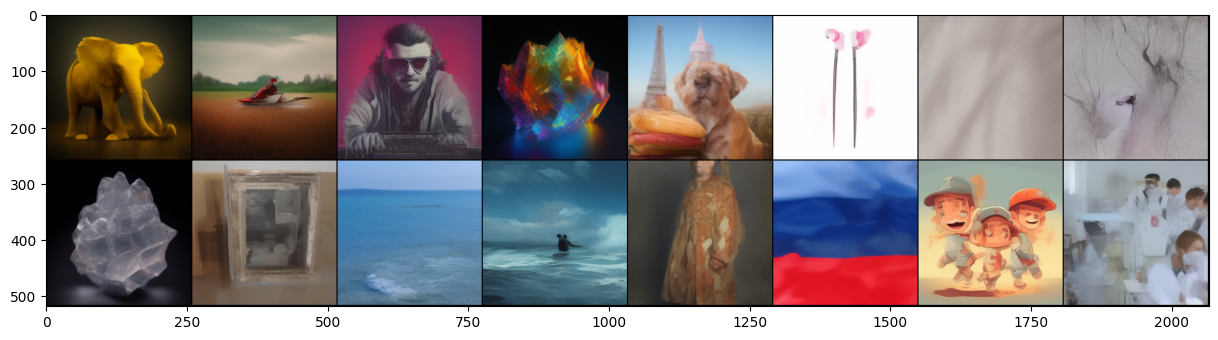

In [31]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=2,
    device=device,
    n_steps=5
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

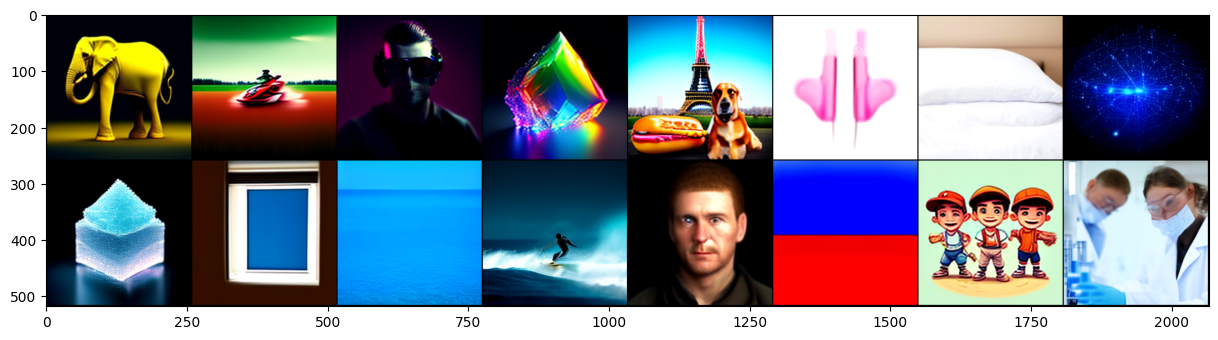

In [32]:
x_gen_cfg = generate_euler_cfg(
    unet=rf_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=2,
    device=device,
    n_steps=5
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

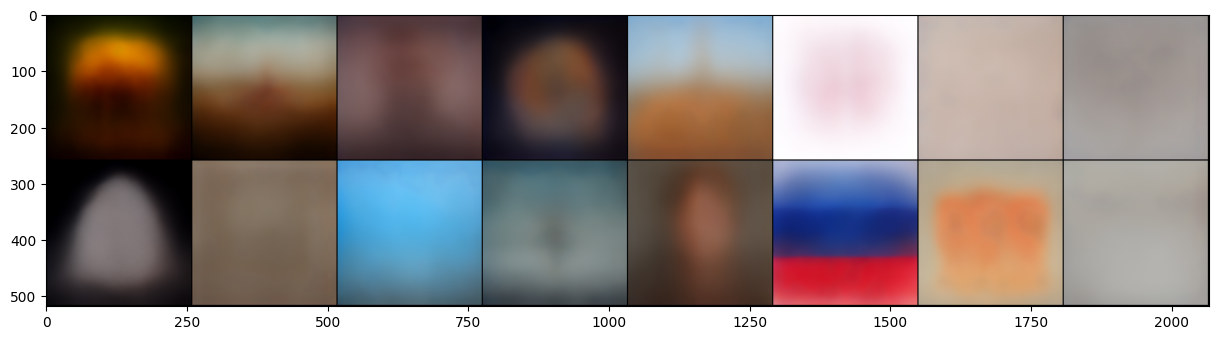

In [33]:
x_gen_cfg = generate_euler_cfg(
    unet=base_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=2,
    device=device,
    n_steps=1
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

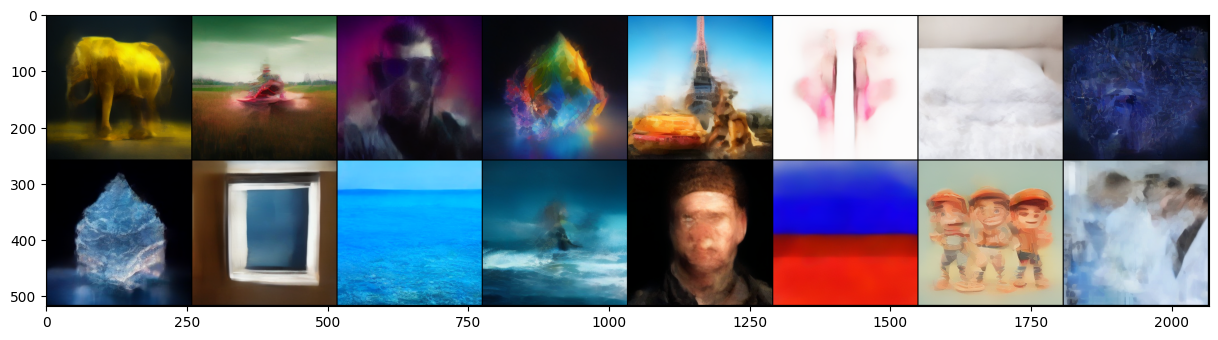

In [34]:
x_gen_cfg = generate_euler_cfg(
    unet=rf_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=1,
    device=device,
    n_steps=1
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

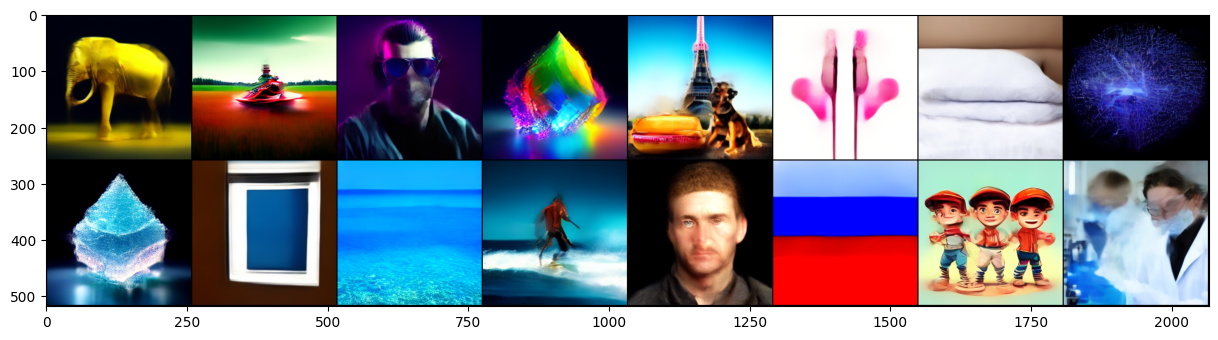

In [35]:
x_gen_cfg = generate_euler_cfg(
    unet=rf_distil_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    null_encoder_hidden_states=null_encoder_hidden_states, 
    guidance_scale=1,
    device=device,
    n_steps=1
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

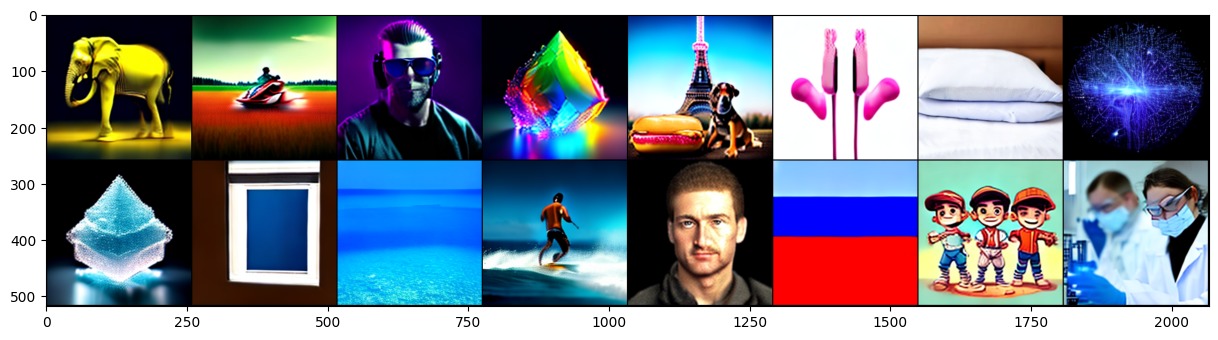

In [38]:
x_gen_cfg = generate_midpoint(
    unet=rf_distil_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    device=device,
    n_steps=1
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))

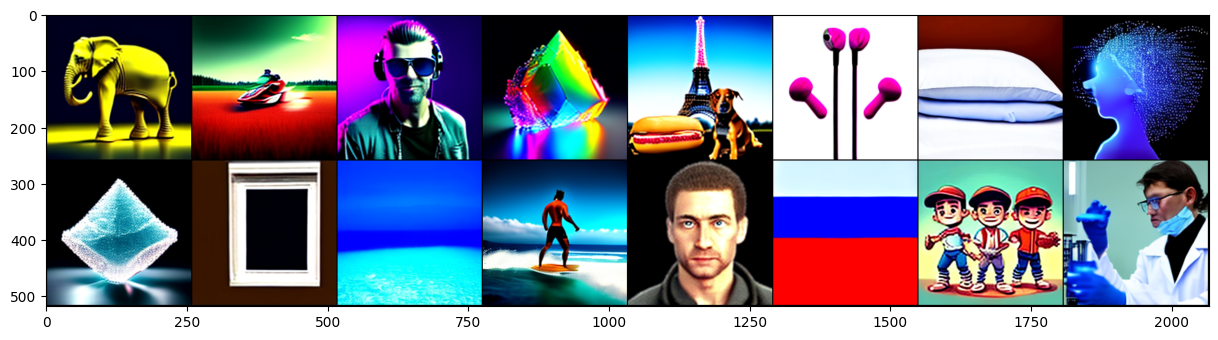

In [41]:
x_gen_cfg = generate_midpoint(
    unet=rf_distil_unet, 
    vae=vae, 
    x_0=x_0_latent[:16], 
    encoder_hidden_states=encoder_hidden_states[:16], 
    device=device,
    n_steps=20
)

plt.figure(figsize=(15, 7))
plt.imshow(show_images(x_gen_cfg))